<a href="https://colab.research.google.com/github/china-zhangdj/magicweb/blob/main/%E2%80%9Cbeamform_image_ipynb%E2%80%9D%E7%9A%84%E5%89%AF%E6%9C%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<h1>平面波波束形成教程</h1>

这是平面波超声波束形成的实践介绍。 在本练习中，我们将了解获取的原始超声数据以及如何将其转换为实际图像。

<br>

<h2>主要要点</h2>

- 了解超声波原始数据，
- 了解平面波束形成器的必要处理元件，以及
- 并能够执行超声图像的质量估计。
<br>

<h2>补充信息</h2>

这个实例是***格拉茨科技大学***系列讲座***电子系统的开发***和***生物医学工程实验室基础***的一部分。
该程序是免费软件，并根据 ***Apache License v2.0*** 获得许可（有关详细信息，请参阅 github LICENSE 文件）。 也可引用：***Leitner, C. (2022)。 记录和处理人体机电信号的新方向。 论文。 格拉茨科技大学.***

<br>

<h2>其他免费超声资源的不完整列表：</h2>

*   <a href="http://www.k-wave.org/">k 波超声模拟器</a> - 免费的 MATLAB 和 C++ 实现
*   <a href="https://field-ii.dk/">Field II 超声模拟器</a> - 免费 MATLAB 实现
*   <a href="https://github.com/Sergio5714/pybf">pybf - Python 波束形成器</a> - 针对短处理时间进行了优化
*   <a href="https://www.biomecardio.com/MUST/">MATLAB 超声工具箱</a> - 免费 MATLAB 波束形成器<br><br>
<br><br>

我希望每个人都能深入了解这个主题，如果有**任何**问题，请随时<a href="mailto:christoph.leitner@tugraz.at">联系</a>我！

你的，<br>
克里斯托夫<br><br>

<br>
<br>


---




# 介绍


<br>

**但是什么是波束成形？** 本质上，这涉及为发射事件 (TX) 生成超声波（波束图案），并根据压电陶瓷上反射的超声波或接收信号 (RX) 重建图像。

<br>

**简化：** 对于超声图像重建，我们做了一些额外的假设，例如。
- 声音以恒定的声速在整个组织中传播，
- 声音沿直线传播，
- 声音在整个组织中衰减相同的量。

然而，所有这些假设都只是模型的简化。 因此，我们必须意识到，如果不满足这些基本假设之一，则可能会发生图像失真。

<br>

<h2>平面波波束形成原理</h2>

这种波束成形方法可能是最简单的入门方法。 在**平面波波束形成**中，所有换能器元件同时激活，产生单个未聚焦的超声波平面波，该波沿直线传播到组织中（见下图）。

<br>

<figure>
<center>
<img src='https://raw.githubusercontent.com/luuleitner/dasIT/main/example_data/ColabBFfigures/PlaneWaveBF.gif'/ width="1200">
</figure>

<br>

**这如何简化事情？** 使用波束形成器，我们必须解决逆问题，即将超声波信号幅度从时间通道空间转移到图像空间。 在波束成形平面波的情况下，解决方案简化为简单的几何公式（我们稍后会看到它们）。

<br>

---

# 1.入门


```
[#] 像这样显示的区域是可执行代码。 使用鼠标悬停播放按钮来运行这些单元格。
```

## 安装
首先我们需要从安装beamformer包<a href="https://github.com/luuleitner/dasIT">GitHub 存储库</a>:

In [ ]:
# 从 github 存储库获取最新的 dasIT 包

!pip install git+https://github.com/luuleitner/dasIT

  Cloning https://github.com/luuleitner/dasIT to /tmp/pip-req-build-ly01mwe6
  Running command git clone --filter=blob:none --quiet https://github.com/luuleitner/dasIT /tmp/pip-req-build-ly01mwe6
  Resolved https://github.com/luuleitner/dasIT to commit 90fb979bb1c120072c50af05187745e0c745b7f7
  Preparing metadata (setup.py) ... done
  Created wheel for dasIT: filename=dasIT-1.0-py3-none-any.whl size=23668 sha256=c0570f9aa5789d9e0bcb8173ca08835a64908b94672be63616d31b60a35d5124
  Stored in directory: /tmp/pip-ephem-wheel-cache-iwtuuhik/wheels/4a/bd/24/5a9617bac414b0abeddd423f6ed36e22416933353eeb668af8
Successfully built dasIT


接下来，我们将所有其他必要的库加载到 Colab 笔记本中：

In [ ]:
# import necessary packages
import os
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei'] # 步骤一（替换sans-serif字体）
plt.rcParams['axes.unicode_minus'] = False   # 步骤二（解决坐标轴负数的负号显示问题）


# to run dasIT, we need to import the necessary commands from the library
from dasIT.data.loader import RFDataloader, TDloader, TGCloader
from dasIT.features.transducer import transducer
from dasIT.features.medium import medium
from dasIT.features.tgc import tg_compensation
from dasIT.src.delays import planewave_delays
from dasIT.src.apodization import apodization
from dasIT.src.das_bf import RXbeamformer
from dasIT.features.signal import RFfilter, fftsignal, analytic_signal
from dasIT.features.image import interp_lateral
from dasIT.visualization.signal_callback import amp_freq_1channel, amp_1channel
from dasIT.visualization.image_callback import plot_signal_grid, plot_signal_image
from dasIT.features.signal import logcompression

## 下载示例数据集

In [ ]:
# 从github下载数据集

# 数据是在工作过程中获得的：Leitner 等人。 2020 年，“使用超快超声检测体内深层和羽状骨骼肌中的运动终板”，2020 年 IEEE 国际超声研讨会 (IUS)。

rfdata_path = '/content/rfdata'

if os.path.exists(rfdata_path) == False:
  os.mkdir(rfdata_path)
  os.chdir(rfdata_path)
  !wget -i https://raw.githubusercontent.com/luuleitner/dasIT/main/example_data/CIRSphantom_GE9LD_VVantage/COLABdownload_url.txt

os.chdir(rfdata_path)

### 数据集的编译
使用 **GE-9LD** 传感器和 **CIRS 通用** 超声模型在 **Verasonics Vantage 256** 超声研究系统上捕获了五个帧。

下图显示了使用 GE-9LD 换能器（右）在超声模型（中）上捕获的重建超声图像（左）。

<figure>
<center>
<img src='https://raw.githubusercontent.com/luuleitner/dasIT/main/example_data/ColabBFfigures/ExperimentalSetup.jpg'/ width="1200">
</figure>

# 2.定义硬件和成像介质

首先，我们需要为我们的软件提供几个静态参数。 特别是，我们必须定义所使用的超声硬件（例如换能器设计等）、发射的超声信号（例如所使用的超声频率等）以及介质的定义（例如声速、尺寸、像素等）。 ）位于超声波透镜下方。

我们假设组织中的声速恒定 (**v = 1540 m/s**)。 该模型假设使我们能够通过关系 v=s/t 和反射声延迟时间的测量（Puls-Echo 方法）来推断反射回声的组织深度。

## 传感器

根据上面给出的传感器规格，填写以下必要的参数：

In [ ]:
# dasIT transducer
physical_transducer = TDloader('transducer.csv')
dasIT_transducer = transducer(center_frequency_hz =5_300_000 ,  # <--- FILL IN CENTER FREQUENCY OF THE TRANSDUCER IN [Hz]
                              bandwidth_hz=physical_transducer.transducer['bandwidth'].dropna().to_numpy(dtype='float', copy=False),    # [Hz]
                              adc_ratio=4,  # [-]
                              transducer_elements_nr = 192, # <--- FILL IN THE NUMBER OF TRANSDUCER ELEMENTS [#]
                              element_pitch_m = 0.00023, # <--- FILL IN THE ELEMENT PITCH IN [m]
                              pinmap=physical_transducer.transducer['pinmap'].dropna().to_numpy(dtype='int', copy=False),   # [-]
                              pinmapbase=1, # [-]
                              elevation_focus=0.028, # [m]
                              focus_number=None,
                              totalnr_planewaves=1,     # [-]
                              planewave_angle_interval=[0,0],   # [rad]
                              axial_cutoff_wavelength=5,  # [#]
                              speed_of_sound_ms = 1540)  # <--- FILL IN THE SPEED OF SOUND IN [m/s]

In [ ]:
# 打印传感器规格

print(f'Transducer properties:')
print()
vars(dasIT_transducer)

Transducer properties:



{'_f_center': 5300000.0,
 '_bandwidth': array([3312500., 7287500.]),
 '_samples_per_wavelength': 4,
 '_f_sampling': 21200000.0,
 '_transducer_elements': 192,
 '_element_pitch': 0.00023,
 '_lateral_transducer_spacing': array([-0.02208   , -0.0218488 , -0.02161759, -0.02138639, -0.02115518,
        -0.02092398, -0.02069277, -0.02046157, -0.02023037, -0.01999916,
        -0.01976796, -0.01953675, -0.01930555, -0.01907435, -0.01884314,
        -0.01861194, -0.01838073, -0.01814953, -0.01791832, -0.01768712,
        -0.01745592, -0.01722471, -0.01699351, -0.0167623 , -0.0165311 ,
        -0.0162999 , -0.01606869, -0.01583749, -0.01560628, -0.01537508,
        -0.01514387, -0.01491267, -0.01468147, -0.01445026, -0.01421906,
        -0.01398785, -0.01375665, -0.01352545, -0.01329424, -0.01306304,
        -0.01283183, -0.01260063, -0.01236942, -0.01213822, -0.01190702,
        -0.01167581, -0.01144461, -0.0112134 , -0.0109822 , -0.01075099,
        -0.01051979, -0.01028859, -0.01005738, -0.009

## Medium

我们成像的介质的大小通常通过关系式 lambda = c/f 在“波长数”中指定。 我们不必太担心这些定义，只需加载成像介质的规格即可。

In [ ]:
# dasIT medium
dasIT_medium = medium(speed_of_sound_ms = 1540, # [m/s]
                      center_frequency = dasIT_transducer.center_frequency, # [Hz]
                      sampling_frequency = dasIT_transducer.sampling_frequency, # [Hz]
                      max_depth_wavelength = 177,   # [#]
                      lateral_transducer_element_spacing = dasIT_transducer.lateral_transducer_spacing, # [m]
                      axial_extrapolation_coef = 1.05,  # [-]
                      attenuation_coefficient= 0.75,   # [dB/(MHz^y cm)]
                      attenuation_power=1.5   # [-]
                      )

# 3.数据整理

从超声研究系统中，我们通常会获得比实际需要更多的信息（由于系统的内存分配），并且通道数据通常是未排序的。 因此，我们在开始之前需要先“清理”一下。 因此，我们切断未分配的样本（零值）并按从 1-192 的升序对通道数据进行排序。

<figure>
<center>
<img src='https://raw.githubusercontent.com/luuleitner/dasIT/main/example_data/ColabBFfigures/DataPreperation.jpg'/ width="1200">
</figure>


In [ ]:
### Load RF Data
RFdata = RFDataloader('CIRS_phantom.h5')

### Preprocess (Clip and Sort) RF Data
# Samples start: at first recorded echo (number of wavelength distance is provided from vendor)
# -> null out the rest to not overshadow the real results
# Samples end: at penetration depth -> clip rest of samples without data
# If necessary sort the transducer channels according to the pin map to get the channels first-last channel
RFdata.signal[:dasIT_transducer.start_depth_rec_samples, :, :] = 0
RFdata.signal = RFdata.signal[:dasIT_medium.rx_echo_totalnr_samples, dasIT_transducer.transducer_pinmap, :]

print(f'Channels of transducer: {RFdata.signal.shape[1]}')
print(f'Samples per channel: {RFdata.signal.shape[0]}')
print(f'Number of frames: {RFdata.signal.shape[2]}')

Channels of transducer: 192
Samples per channel: 1416
Number of frames: 5


## 探索原始数据 - 波束成形原理

I现在，我们随时间绘制经过排序和修剪的通道数据（左图），点状回波（右图中的幻影反射器）显示在 x,t 图中，呈双曲线。

**使用我们的波束形成器，我们现在需要解决逆问题并将原始超声数据（时间和通道空间）传输到图像（宽度和高度空间）**。

<figure>
<center>
<img src='https://raw.githubusercontent.com/luuleitner/dasIT/main/example_data/ColabBFfigures/Beamformer_xt_xz.jpg'/ width="1200">
</figure>

### 探索单个通道的数据
我们来看看**156频道**的原始数据。 我们绘制随时间变化的信号幅度。

/usr/local/lib/python3.10/dist-packages/dasIT/features/signal.py:86: RuntimeWarning: divide by zero encountered in log10
  logcomp_signal = (20 * np.log10(envelope(signal))) - np.nanmax((20 * np.log10(envelope(signal))))
/usr/local/lib/python3.10/dist-packages/dasIT/features/signal.py:86: RuntimeWarning: invalid value encountered in log10
  logcomp_signal = (20 * np.log10(envelope(signal))) - np.nanmax((20 * np.log10(envelope(signal))))
<ipython-input-25-6d2f827233d8>:33: UserWarning: Glyph 20256 (\N{CJK UNIFIED IDEOGRAPH-4F20}) missing from current font.
  plt.tight_layout()
<ipython-input-25-6d2f827233d8>:33: UserWarning: Glyph 24863 (\N{CJK UNIFIED IDEOGRAPH-611F}) missing from current font.
  plt.tight_layout()
<ipython-input-25-6d2f827233d8>:33: UserWarning: Glyph 22120 (\N{CJK UNIFIED IDEOGRAPH-5668}) missing from current font.
  plt.tight_layout()
<ipython-input-25-6d2f827233d8>:33: UserWarning: Glyph 20803 (\N{CJK UNIFIED IDEOGRAPH-5143}) missing from current font.
  plt.tight_

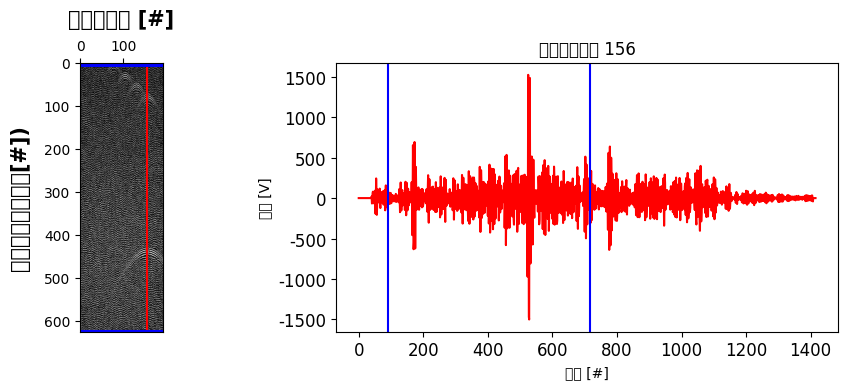


通道 156 以红色表示。
左侧时间信号图中的可见区域在右侧通道图中用蓝线标记。


In [ ]:
cutoff_lens = 90
cutoff_depth = len(RFdata.signal) - 700

channel = 156
dbrange = 55
signal = logcompression(RFdata.signal[:,:,0], dbrange)

fig = plt.figure(figsize=(10, 4), dpi=100)
ax_1 = fig.add_subplot(121)
ax_1.imshow(signal[90:-700, :],
            aspect=1,
            cmap='gray')

ax_1.set_xlabel('传感器元件 [#]', fontsize=15, fontweight='bold', labelpad=10)
ax_1.set_ylabel('流逝的时间（样本[#])', fontsize=15, fontweight='bold', labelpad=10)
ax_1.xaxis.tick_top()
ax_1.xaxis.set_label_position('top')
ax_1.axvline(x=channel, color='red')
ax_1.axhline(y=0, color='blue', lw=5)
ax_1.axhline(y=cutoff_depth-cutoff_lens-2, color='blue')


ax_2 = fig.add_subplot(122)
ax_2.plot(RFdata.signal[:,channel,0], 'r')
ax_2.set_xlabel('样本 [#]')
ax_2.set_ylabel('信号 [V]')
ax_2.set_title(f'射频数据通道 {channel}')
ax_2.axvline(x=cutoff_lens, color='blue',)
ax_2.axvline(x=cutoff_depth, color='blue')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

print('')
print('通道 156 以红色表示。\n左侧时间信号图中的可见区域在右侧通道图中用蓝线标记。')

# 4.信号处理

### 时间增益补偿


我们假设组织中各处的声波吸收程度相同（这在形式上并不正确，因为不同的组织类型吸收的量不同）。 声波的压力振幅在穿过组织传播时由于衰减而损失能量。 因此，来自较深结构的反射显得较弱。 因此，通常通过添加与时间相关的增益来对记录的射频数据进行时间增益校正，以补偿衰减损失。

<figure>
<center>
<img src='https://raw.githubusercontent.com/luuleitner/dasIT/main/example_data/ColabBFfigures/TGC.jpg'/ width="1200">
</figure>

In [ ]:
# 加载并应用 tgc 波形
tgc_cntrl_points = TGCloader(controlpt_path='tgc_cntrl_pt.csv')
TGCsignals = tg_compensation(signals=RFdata.signal,
                             medium=dasIT_medium,
                             center_frequency=dasIT_transducer.center_frequency,
                             cntrl_points=tgc_cntrl_points,
                             mode='points')

<ipython-input-22-029b45e285c0>:15: UserWarning: Glyph 26679 (\N{CJK UNIFIED IDEOGRAPH-6837}) missing from current font.
  plt.tight_layout()
<ipython-input-22-029b45e285c0>:15: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from current font.
  plt.tight_layout()
<ipython-input-22-029b45e285c0>:15: UserWarning: Glyph 20449 (\N{CJK UNIFIED IDEOGRAPH-4FE1}) missing from current font.
  plt.tight_layout()
<ipython-input-22-029b45e285c0>:15: UserWarning: Glyph 21495 (\N{CJK UNIFIED IDEOGRAPH-53F7}) missing from current font.
  plt.tight_layout()
<ipython-input-22-029b45e285c0>:15: UserWarning: Glyph 23556 (\N{CJK UNIFIED IDEOGRAPH-5C04}) missing from current font.
  plt.tight_layout()
<ipython-input-22-029b45e285c0>:15: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from current font.
  plt.tight_layout()
<ipython-input-22-029b45e285c0>:15: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  plt.tight_layout()
<ipyth

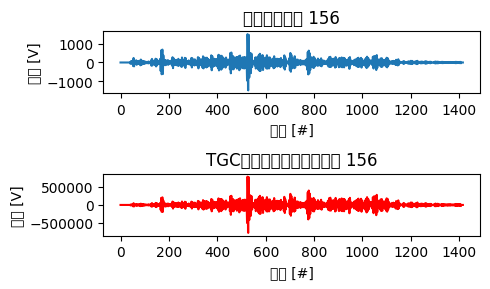

In [ ]:
# 绘制通道156
fig = plt.figure(figsize=(5, 3), dpi=100)
ax_1 = fig.add_subplot(211)
ax_1.plot(RFdata.signal[:,channel,0])
ax_1.set_xlabel('样本 [#]')
ax_1.set_ylabel('信号 [V]')
ax_1.set_title(f'射频数据通道 {channel}')

ax_2 = fig.add_subplot(212)
ax_2.plot(TGCsignals.signals[:,channel,0],'r')
ax_2.set_xlabel('样本 [#]')
ax_2.set_ylabel('信号 [V]')
ax_2.set_title(f'TGC补偿后的射频数据通道 {channel}')

plt.tight_layout()
plt.show()

###滤波

为了消除不需要的噪声，我们使用 FIR 带通滤波器和高斯窗过滤原始数据。 我们使用换能器带宽的上限和下限作为截止频率。

In [ ]:
### 对RF数据进行滤波
RFdata_filtered = RFfilter(signals=TGCsignals.signals,
                           fcutoff_band=dasIT_transducer.bandwidth,
                           fsampling=dasIT_transducer.sampling_frequency,
                           type='gaussian',
                           order=10)

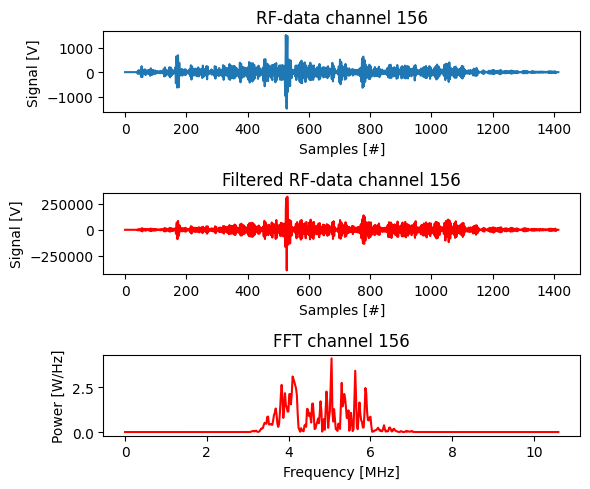

In [ ]:
# 绘制通道156
fftFil = fftsignal(RFdata_filtered.signal[:,channel,0], dasIT_transducer.sampling_frequency)

fig = plt.figure(figsize=(6, 5), dpi=100)
ax_1 = fig.add_subplot(311)
ax_1.plot(RFdata.signal[:,channel,0])
ax_1.set_xlabel('Samples [#]')
ax_1.set_ylabel('Signal [V]')
ax_1.set_title(f'RF-data channel {channel}')

ax_2 = fig.add_subplot(312)
ax_2.plot(RFdata_filtered.signal[:,channel,0],'r')
ax_2.set_xlabel('Samples [#]')
ax_2.set_ylabel('Signal [V]')
ax_2.set_title(f'Filtered RF-data channel {channel}')

ax_3 = fig.add_subplot(313)
ax_3.plot(fftFil[0], fftFil[1], 'r')
ax_3.set_xlabel('Frequency [MHz]')
ax_3.set_ylabel('Power [W/Hz]')
ax_3.set_title(f'FFT channel {channel}')

plt.tight_layout()
plt.show()

### 转换为分析信号l

在超声领域，我们更喜欢使用信号包络来表示数据。我们显示波动的原始信号的瞬时能量分布。 因此，我们必须首先使用希尔伯特变换计算原始数据的分析信号。

In [ ]:
####################################################################
#------------------------ 分析信号 -----------------------#

### 希尔伯特变换
RFdata_analytic = analytic_signal(np.squeeze(RFdata_filtered.signal), interp=False)

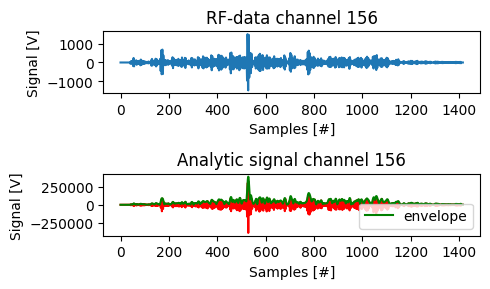

In [ ]:
# 绘制通道156
fftFil = fftsignal(RFdata_filtered.signal[:,channel,0], dasIT_transducer.sampling_frequency)

fig = plt.figure(figsize=(5, 3), dpi=100)
ax_1 = fig.add_subplot(211)
ax_1.plot(RFdata.signal[:,channel,0])
ax_1.set_xlabel('Samples [#]')
ax_1.set_ylabel('Signal [V]')
ax_1.set_title(f'RF-data channel {channel}')

ax_2 = fig.add_subplot(212)
ax_2.plot(RFdata_analytic[:,channel,0].real,'r')
ax_2.plot(abs(RFdata_analytic[:,channel,0]),'g', label='envelope')
ax_2.set_xlabel('Samples [#]')
ax_2.set_ylabel('Signal [V]')
ax_2.set_title(f'Analytic signal channel {channel}')
ax_2.legend(loc='lower right')

plt.tight_layout()
plt.show()

# 5.波束成形


为了解决波束形成操作，信号幅度必须从（x，时间）域转移到（z，x）平面。 下图描述了计算确定所需时间延迟所需的数学运算
每个像素点的信号幅度：

<figure>
<center>
<img src='https://raw.githubusercontent.com/luuleitner/dasIT/main/example_data/ColabBFfigures/PWbeamforming.jpg'/ width="800">
</figure>


### 使用变迹表考虑元素方向性和焦点

由于元件的方向性，换能器元件不能在所有方向上同等地发射和接收。 因此，只有元件的部分孔径对信号幅度有贡献（返回波具有双曲线形状）。 变迹表中已考虑到这一点。

In [ ]:
####################################################################
#-------------------------- 变迹表 --------------------------#

apodization = apodization(delays=None,
                          medium=dasIT_medium.medium,
                          transducer=dasIT_transducer,
                          apo='rec',
                          angles=dasIT_transducer.planewave_angles())

### 设置信号转换延迟表

在这里，我们计算超声波脉冲的发射、对反射器目标的影响以及到换能器的背反射之间的信号延迟element.

In [ ]:
####################################################################
#-------------------------- 延迟表 --------------------------#

### 用于倾斜平面波的 DAS 延迟片
delay_table = planewave_delays(medium=dasIT_medium.medium,
                               sos=dasIT_medium.speed_of_sound,
                               fsampling=dasIT_transducer.sampling_frequency,
                               angles=dasIT_transducer.planewave_angles())

Time to initialize delay tables: 1.43756 [s]


###波束成形

现在我们将变迹和延迟表应用于处理后的原始超声数据。 在这一步中，我们解决逆问题并将时间通道数据

In [ ]:
####################################################################
#-------------------------- 波束成形 ---------------------------#
start_das_timing = datetime.now()

# 已包含在重建中的轴向掩模图像区域
# 但不是实际图像的一部分。
RFsignals = RFdata_analytic[:,:,0]

RFsignals = np.expand_dims(RFsignals, 2)
RFsignals = np.repeat(RFsignals, RFsignals.shape[1], axis=2)
RFsignals = np.expand_dims(RFsignals, 3)

BFsignals = RXbeamformer(signals=RFsignals,
                         delays=delay_table.sample_delays,
                         apodization=apodization.table)

# 6.图像形成

所谓的动态范围定义了最高信号幅度（靠近镜头的最强回波）和最低信号幅度（来自深层目标的微弱回波）之间的对数比。 假设波束形成数据被线性映射到灰度图像上，则重要的组织特征会丢失，因为一些具有高振幅回波的回波遮盖了图像空间的其余部分。 因此，我们通过对数调整回波幅度来平衡动态范围。

就是这样。 现在我们可以以图形方式绘制结果：

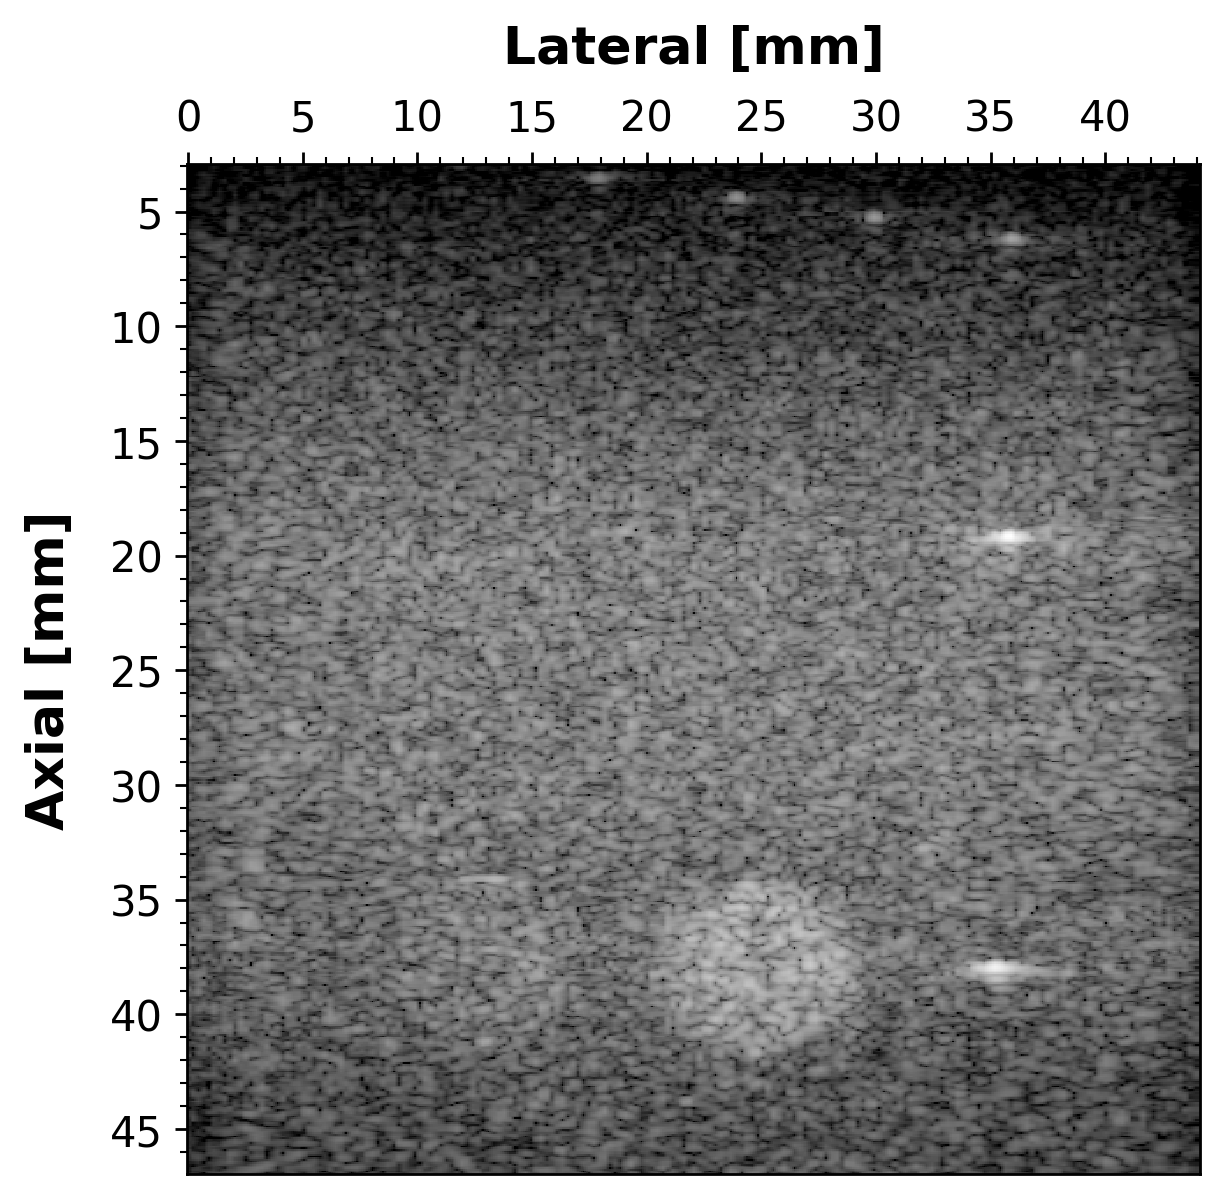

In [ ]:
####################################################################
#------------------------ 图像形成 --------------------------

# 包络
BFsignals.envelope = abs(BFsignals.frame)

# 在横向空间上插值
BFsignals.interpolated = interp_lateral(signals=BFsignals.envelope,
                                        transducer=dasIT_transducer,
                                        medium=dasIT_medium,
                                        scale=3)


# 绘图图像
plot_signal_grid(signals=BFsignals.interpolated.signals_lateral_interp,
                 axis_vectors_xz=BFsignals.interpolated.imagegrid_mm,
                 axial_clip=[dasIT_transducer.start_depth_rec_m, None],
                 compression=True,
                 dbrange=58,
                 path=rfdata_path)

# 7.计算图像分辨率

对于近场中的指示点目标（下图），计算波束形成图像的轴向和横向分辨率。
<figure>
<center>
<img src='https://raw.githubusercontent.com/luuleitner/dasIT/main/example_data/ColabBFfigures/Resolution.jpg'/ width="300">
</figure>


指示：
- 使用尺子测量反射目标在横向和轴向上的全宽度（起点和终点）。
- 1 个全宽度大约等于 6 个标准差 (± 3$\sigma$ = 99.73%)。
- 将全宽度除以 6 即可得到 1 西格玛的近似值。
- 使用高斯分布计算半高全宽 (FWHM)： $FWHM = 2 \sqrt{2 ln2} * \sigma$
- 您可以进行计算 <a href="https://www.wolframalpha.com/">https://www.wolframalpha.com/</a>